Import Libraries

In [1]:
!pip install tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 30.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as k
import time
from tensorflow.keras.callbacks import EarlyStopping

# 1. Process MNIST dataset

Assign training and test data

In [3]:
batch_size = 128
num_classes = 10
img_rows, img_cols = 28,28
(x_train,y_train),(x_test,y_test) =   mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


Reshape the images

In [4]:
if k.image_data_format()=='channels_first':
    x_train=x_train.reshape(x_train.shape[0],img_rows,img_cols,1)
    x_test=x_test.reshape(x_test.shape[0],img_rows,img_cols,1)
else:
    x_train=x_train.reshape(x_train.shape[0],img_rows,img_cols,1)
    x_test=x_test.reshape(x_test.shape[0],img_rows,img_cols,1)

input_shape=(img_rows,img_cols,1)
x_train = x_train/255.0
x_test=x_test/255.0
print('x_train shape:',x_train.shape,'\nx_test shape:',x_test.shape)

x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)


Convert class vectors to binary class matrices

In [5]:
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

# 2. CNN no Attention

Design the CNN architecture

In [6]:
from keras.models import Sequential
from keras import layers

In [7]:
model=Sequential()

model.add( layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape) )
model.add( layers.MaxPooling2D(pool_size=(2,2)) )
model.add( layers.Dropout(0.2) )
model.add( layers.Flatten() )
model.add( layers.Dense(32,activation='relu') )
model.add( layers.Dense(num_classes,activation='softmax') )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 32)                173088    
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                        

In [10]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy']
             )
early_stopping = EarlyStopping(monitor='accuracy', patience=3)
tic=time.time()
hist = model.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=15,
                verbose=1,
                callbacks=[early_stopping],
                validation_data=(x_test,y_test)
                )
toc=time.time()
training_time=toc-tic

Epoch 1/15
469/469 [==============================] - 4s 5ms/step - loss: 0.0208 - accuracy: 0.9930 - val_loss: 0.0439 - val_accuracy: 0.9871
Epoch 2/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0180 - accuracy: 0.9944 - val_loss: 0.0466 - val_accuracy: 0.9870
Epoch 3/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0157 - accuracy: 0.9952 - val_loss: 0.0450 - val_accuracy: 0.9868
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0143 - accuracy: 0.9951 - val_loss: 0.0479 - val_accuracy: 0.9865
Epoch 5/15
469/469 [==============================] - 3s 5ms/step - loss: 0.0137 - accuracy: 0.9953 - val_loss: 0.0479 - val_accuracy: 0.9865
Epoch 6/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0119 - accuracy: 0.9962 - val_loss: 0.0498 - val_accuracy: 0.9868
Epoch 7/15
469/469 [==============================] - 3s 6ms/step - loss: 0.0114 - accuracy: 0.9961 - val_loss: 0.0477 - val_accuracy: 0.9878
Epoch 

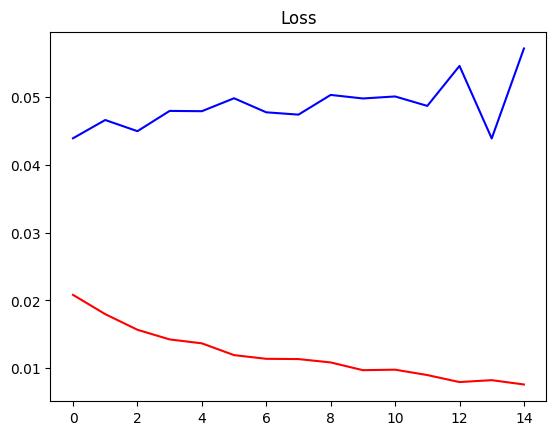

In [11]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

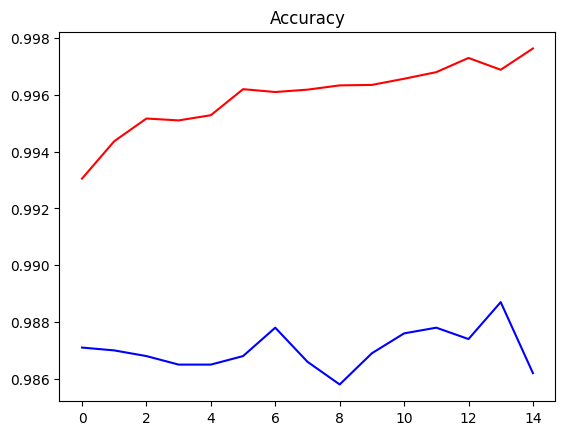

In [13]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

In [14]:
tic=time.time()
test_loss, test_acc = model.evaluate(x_test,y_test)
toc=time.time()
test_time=toc-tic
print("Training Time = {} s".format(np.round(training_time, 1)))
print("Testing Time = {} ms".format(np.round(test_time*1000, 1)))
print('Test Loss = {:.2f} %:'.format(np.round(test_loss, 3)*100))
print('Test Accuracy = {:.2f} %:'.format(np.round(test_acc, 3)*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0571 - accuracy: 0.9862
Training Time = 83.3 s
Testing Time = 901.9 ms
Test Loss = 5.70 %:
Test Accuracy = 98.60 %:


# 3. CNN with Attention

In [15]:
import torch.nn as nn

Design the CNN architecture

In [16]:
inputs = layers.Input(shape=input_shape)
conv = layers.Conv2D(32,kernel_size=(3,3),activation='relu')(inputs)
#Attention
attention = layers.Conv2D(1, (3,3), padding='same', activation='sigmoid')(conv)
attention_mul = layers.Multiply()([conv, attention])
##########
pool = layers.MaxPool2D(pool_size=(2,2))(attention_mul)
drop = layers.Dropout(0.2)(pool)
flatten = layers.Flatten()(drop)
dense = layers.Dense(32,activation='relu')(flatten)
dense2 = layers.Dense(num_classes,activation='softmax')(dense)
modelAtt = keras.Model(inputs=inputs, outputs=dense2)

modelAtt.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 26, 26, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 26, 26, 1)    289         ['conv2d_1[0][0]']               
                                                                                                  
 multiply (Multiply)            (None, 26, 26, 32)   0           ['conv2d_1[0][0]',               
                                                                  'conv2d_2[0][0]']           

In [17]:
modelAtt.compile(optimizer=keras.optimizers.Adam(),
              loss= keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']
             )
tic=time.time()
hist = modelAtt.fit(x_train,y_train,
                    batch_size=batch_size,
                    epochs=15,
                    verbose=1,
                    callbacks=[early_stopping],
                    validation_data=(x_test,y_test)
                    )
toc=time.time()
training_time=toc-tic

Epoch 1/15
469/469 [==============================] - 5s 7ms/step - loss: 0.3364 - accuracy: 0.9056 - val_loss: 0.1149 - val_accuracy: 0.9666
Epoch 2/15
469/469 [==============================] - 3s 6ms/step - loss: 0.1003 - accuracy: 0.9709 - val_loss: 0.0792 - val_accuracy: 0.9749
Epoch 3/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0726 - accuracy: 0.9783 - val_loss: 0.0575 - val_accuracy: 0.9814
Epoch 4/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0603 - accuracy: 0.9818 - val_loss: 0.0496 - val_accuracy: 0.9828
Epoch 5/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0506 - accuracy: 0.9846 - val_loss: 0.0483 - val_accuracy: 0.9841
Epoch 6/15
469/469 [==============================] - 5s 11ms/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.0456 - val_accuracy: 0.9859
Epoch 7/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0408 - accuracy: 0.9879 - val_loss: 0.0457 - val_accuracy: 0.9846
Epoch

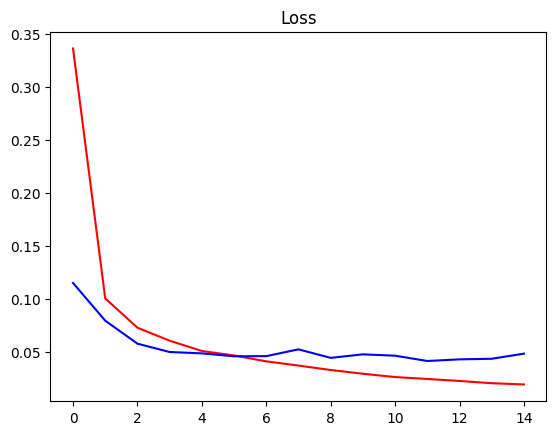

In [18]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

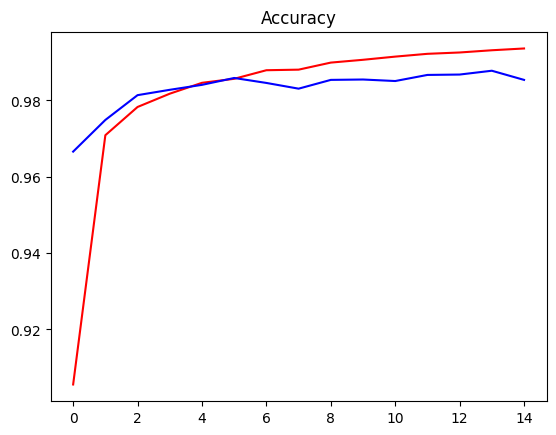

In [19]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

In [20]:
tic=time.time()
test_loss, test_acc = modelAtt.evaluate(x_test,y_test)
toc=time.time()
test_time=toc-tic
print("Training Time = {} s".format(np.round(training_time, 1)))
print("Testing Time = {} ms".format(np.round(test_time*1000, 1)))
print('Test Loss = {:.2f} %:'.format(np.round(test_loss, 3)*100))
print('Test Accuracy = {:.2f} %:'.format(np.round(test_acc, 3)*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.0481 - accuracy: 0.9854
Training Time = 52.4 s
Testing Time = 921.8 ms
Test Loss = 4.80 %:
Test Accuracy = 98.50 %:
